In [1]:
%matplotlib inline

import sys, os
sys.path.insert(0, '../../pytorch-segmentation-detection/vision/')
sys.path.append('../../pytorch-segmentation-detection/')

# Use second GPU -pytorch-segmentation-detection- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from PIL import Image
from matplotlib import pyplot as plt

import torch
from torchvision import transforms
from torch.autograd import Variable
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated

import numpy as np
import glob

import sys; sys.path.append('../dataset')
sys.path.append('../correspondence_tools')
import correspondence_plotter
from spartan_dataset_masked import SpartanDataset


descriptor_dimensionality = 3
nets = sorted(glob.glob("trained_models/10_drill_long_"+str(descriptor_dimensionality)+"d/dense_resnet*.pth"))
print "Networks:"
for net in nets:
    print "   - ", net

lf = SpartanDataset()
scene = "04_drill_long_downsampled"

img_a_index = "001605"
img_a_rgb, img_a_depth, img_a_pose = lf.get_specific_rgbd_with_pose(scene, img_a_index)

img_b_index = "002432"
img_b_rgb, img_b_depth, img_b_pose = lf.get_specific_rgbd_with_pose(scene, img_b_index)

Networks:
   -  trained_models/10_drill_long_3d/dense_resnet_34_8s_03502.pth
   -  trained_models/10_drill_long_3d/dense_resnet_34_8s_03503.pth
   -  trained_models/10_drill_long_3d/dense_resnet_34_8s_03504.pth
   -  trained_models/10_drill_long_3d/dense_resnet_34_8s_03505.pth
Using SpartanDataset:
   - in train mode
   - number of scenes: 8
   - total images:     1581


In [2]:
fcn = resnet_dilated.Resnet34_8s(num_classes=descriptor_dimensionality)

/usr/local/lib/python2.7/dist-packages/torch/nn/modules/module.py:482: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)


In [3]:
valid_transform = transforms.Compose(
                [
                     transforms.ToTensor(),
                ])

def forward_on_img(net, img):
    img = valid_transform(img)
    img = img.unsqueeze(0)
    img = Variable(img.cuda())
    fcn = resnet_dilated.Resnet34_8s(num_classes=descriptor_dimensionality)
    fcn.load_state_dict(torch.load(net))
    fcn.cuda()
    fcn.eval()
    res = fcn(img)
    res = res.squeeze(0)
    res = res.permute(1,2,0)
    res = res.data.cpu().numpy().squeeze()
    return res

res_a = forward_on_img(nets[0], img_a_rgb)
res_b = forward_on_img(nets[0], img_b_rgb)

/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


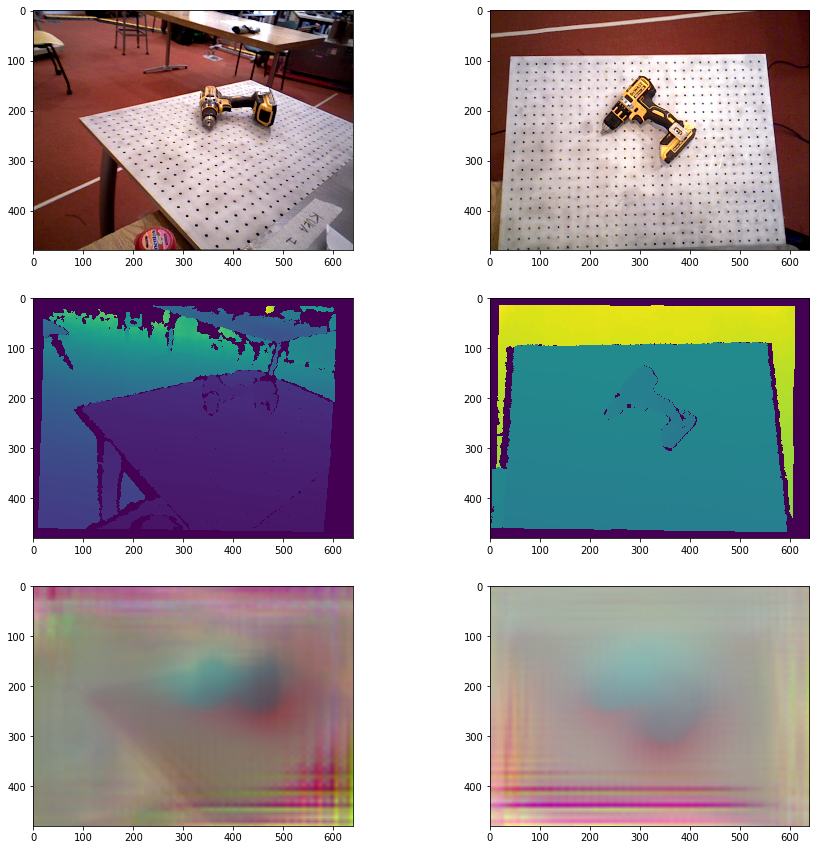

In [4]:
def normalize(res):
    normed_res = res + -np.min(res)
    normed_res = normed_res / np.max(normed_res)
    return normed_res

if (descriptor_dimensionality == 1) or (descriptor_dimensionality == 3):
    fig, axes = plt.subplots(nrows=3, ncols=2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    axes = axes.flat[0:]
    images = [img_a_rgb, img_b_rgb, img_a_depth, img_b_depth, normalize(res_a), normalize(res_b)]
    for ax, img in zip(axes, images):
        ax.imshow(img)
    plt.show()

## What does evolution of descriptors look like?

In [5]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

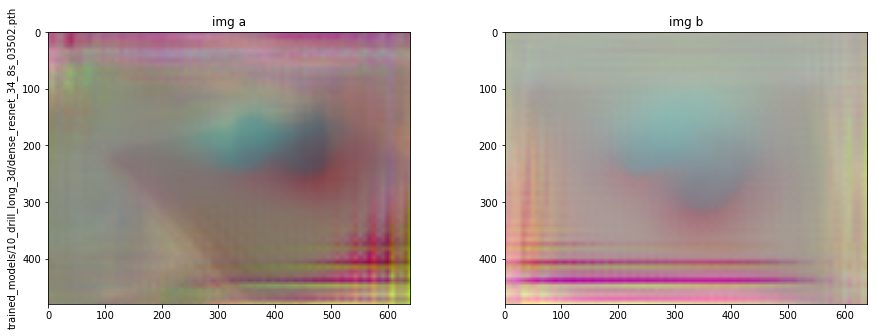

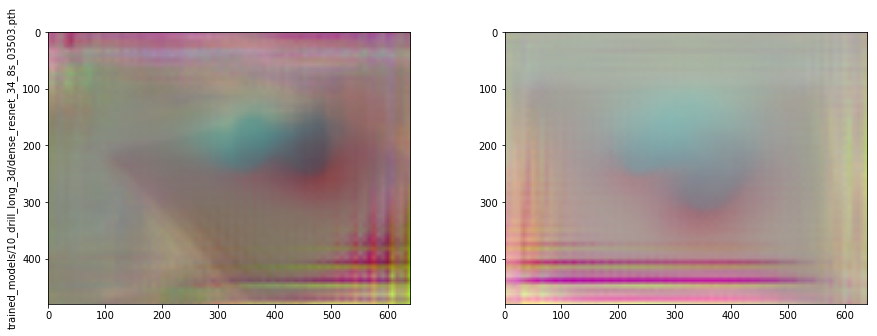

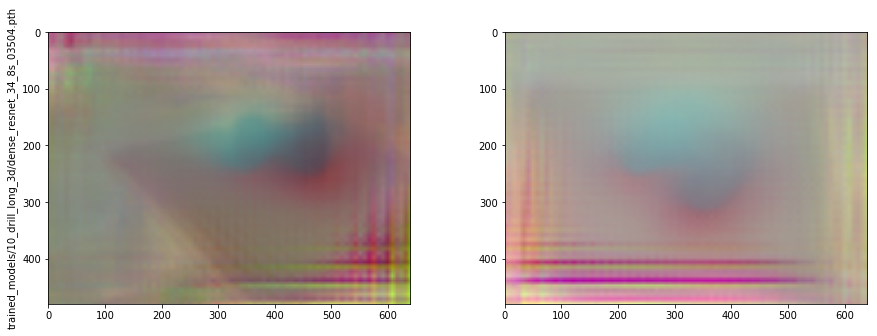

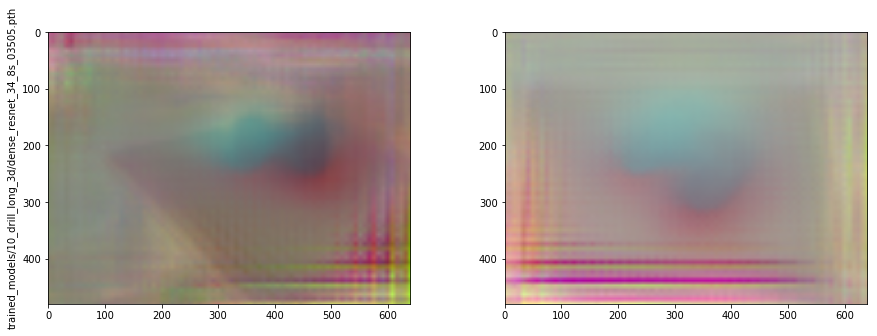

In [6]:
if (descriptor_dimensionality == 1) or (descriptor_dimensionality == 3):
    for index, this_net in enumerate(nets):
        fig, axes = plt.subplots(nrows=1, ncols=2)
        fig.set_figheight(5)
        fig.set_figwidth(15)
        if index == 0:
            axes[0].set_title("img a")
            axes[1].set_title("img b")
        axes[0].imshow(normalize(forward_on_img(this_net, img_a_rgb)))
        axes[1].imshow(normalize(forward_on_img(this_net, img_b_rgb)))
        axes[0].set_ylabel(this_net)
        plt.show()

## How about overlaying these images?



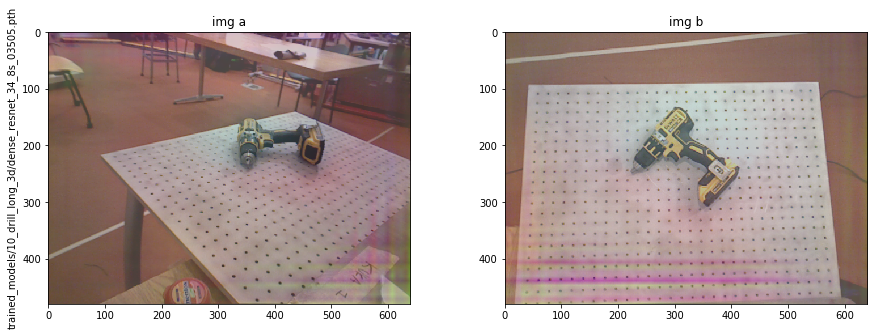

In [7]:
this_net = nets[-1]
if (descriptor_dimensionality == 1) or (descriptor_dimensionality == 3):
    fig, axes = plt.subplots(1, ncols=2)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    axes[0].set_title("img a")
    axes[1].set_title("img b")
    axes[0].imshow(normalize(forward_on_img(this_net, img_a_rgb)))
    axes[0].imshow(img_a_rgb, alpha=0.5)
    axes[1].imshow(normalize(forward_on_img(this_net, img_b_rgb)))
    axes[1].imshow(img_b_rgb, alpha=0.5)
    axes[0].set_ylabel(this_net)
    plt.show()

## What if we plot the heatmap of correspondences between two images?

In [8]:
import correspondence_finder as cf
uv_a, uv_b = cf.batch_find_pixel_correspondences(img_a_depth, img_a_pose, 
                                img_b_depth, img_b_pose, 
                                num_attempts=100)

    # uv_a = (390,390),(171,171)
    # uv_b = (495,495),(322,322)

# first element is width (640 max)
# second element is heigh (480 max)
# switch these here
sample_from_a = (uv_a[1][0], uv_a[0][0])
# now it's 480, 640
res_a = forward_on_img(this_net, img_a_rgb)
# shape is (480, 640, 3)
descriptor_at_pixel = res_a[sample_from_a[0], sample_from_a[1]]
print descriptor_at_pixel

torch.Size([100])
unmasked shape
[ 0.2694982  -0.04289534 -0.3342488 ]


[[0.45252086 0.4357807  0.42030069 ... 0.5564316  0.53689347 0.51870539]
 [0.48039121 0.4630244  0.44696542 ... 0.56730799 0.5503281  0.53462299]
 [0.51229445 0.49423399 0.47753362 ... 0.57972885 0.56510762 0.55174272]
 ...
 [4.07910932 4.02483683 3.97229431 ... 0.63669904 0.60977512 0.58533861]
 [4.26523754 4.20097209 4.13851751 ... 0.61911244 0.5929724  0.56936006]
 [4.45991455 4.38625241 4.31465359 ... 0.60226993 0.57700943 0.55432566]]


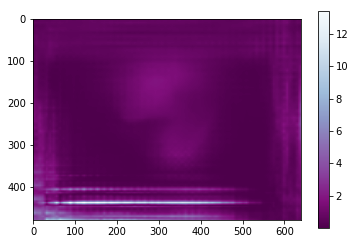

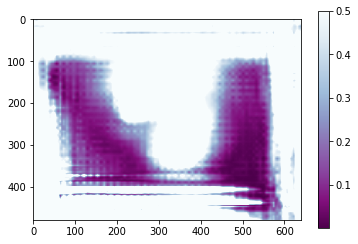

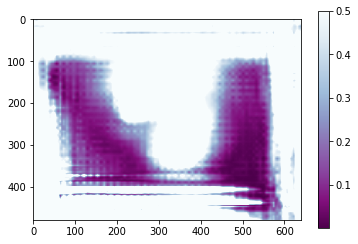

In [9]:
res_b = forward_on_img(this_net, img_b_rgb)
norm_diffs = np.zeros_like(img_b_depth)*0.0
for i, row in enumerate(norm_diffs):
    for j, value in enumerate(row):
        norm_diffs[i][j] = np.linalg.norm(res_b[i][j] - descriptor_at_pixel)**2

print norm_diffs
plt.imshow(norm_diffs, cmap=plt.cm.BuPu_r)
plt.colorbar()
plt.show()
plt.imshow(norm_diffs, cmap=plt.cm.BuPu_r, vmax = 0.5)
plt.colorbar()
plt.show()

norm_diffs_numpy = np.sum(np.square(res_b - descriptor_at_pixel), axis=2)
plt.imshow(norm_diffs, cmap=plt.cm.BuPu_r, vmax = 0.5)
plt.colorbar()
plt.show()

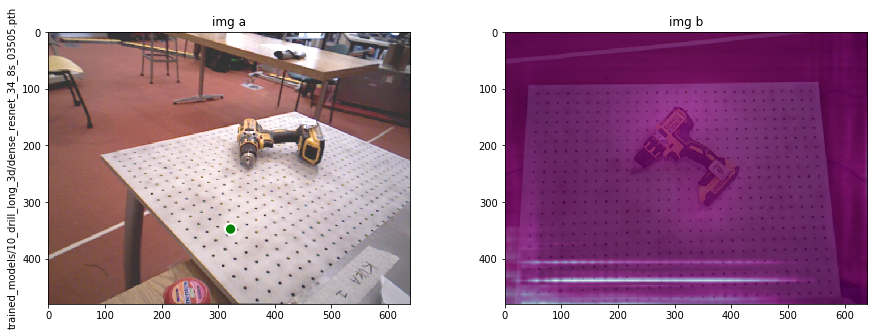

In [11]:
from matplotlib.patches import Circle
fig, axes = plt.subplots(1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(15)
axes[0].set_title("img a")
axes[1].set_title("img b")
circ = Circle(sample_from_a[::-1], radius=10, facecolor='g', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes[0].add_patch(circ)
axes[0].imshow(img_a_rgb, alpha=0.8)
axes[1].imshow(norm_diffs, cmap=plt.cm.BuPu_r)
axes[1].imshow(img_b_rgb, alpha=0.2)
axes[0].set_ylabel(this_net)
plt.show()

## Threshold the heatmap, compute the best predicted match (purple circle), and "ground truth" best match (green)

(480, 640)
descriptor_at_pixel:  (3,)
res_a.shape  (480, 640, 3)
norm_diffs.shape (480, 640)
best_match_tuple:  (422, 543)
best_match:  270623
min_diff:  0.0002498248291918359


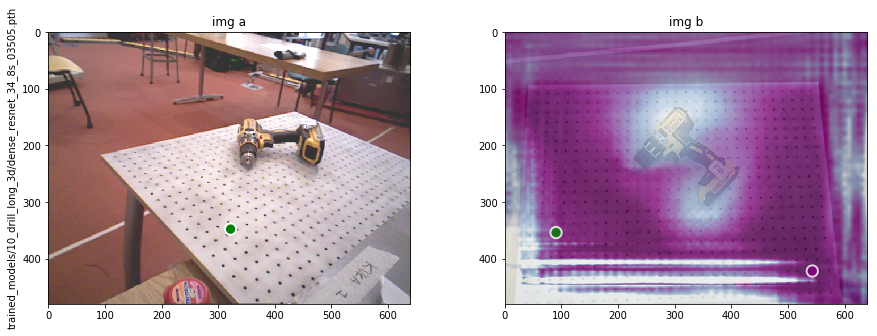

(480, 640)
descriptor_at_pixel:  (3,)
res_a.shape  (480, 640, 3)
norm_diffs.shape (480, 640)
best_match_tuple:  (179, 113)
best_match:  114673
min_diff:  0.0034930163195225905


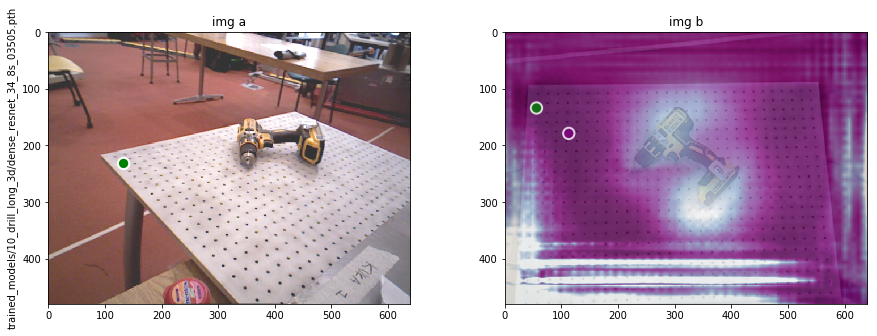

(480, 640)
descriptor_at_pixel:  (3,)
res_a.shape  (480, 640, 3)
norm_diffs.shape (480, 640)
best_match_tuple:  (421, 530)
best_match:  269970
min_diff:  0.0006147170920741164


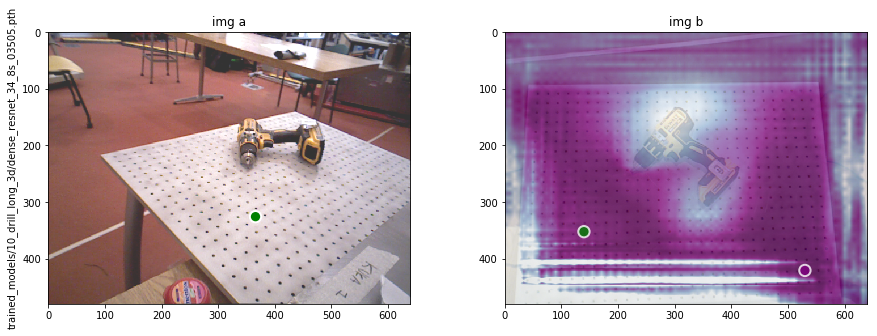

(480, 640)
descriptor_at_pixel:  (3,)
res_a.shape  (480, 640, 3)
norm_diffs.shape (480, 640)
best_match_tuple:  (409, 273)
best_match:  262033
min_diff:  6.746122316501294e-05


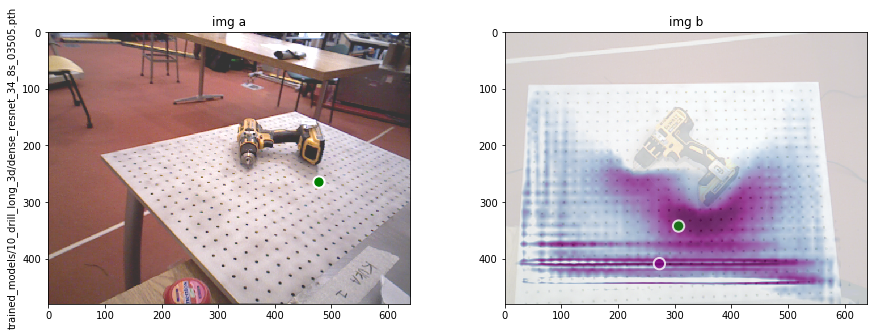

(480, 640)
descriptor_at_pixel:  (3,)
res_a.shape  (480, 640, 3)
norm_diffs.shape (480, 640)
best_match_tuple:  (106, 28)
best_match:  67868
min_diff:  0.00021145048949997372


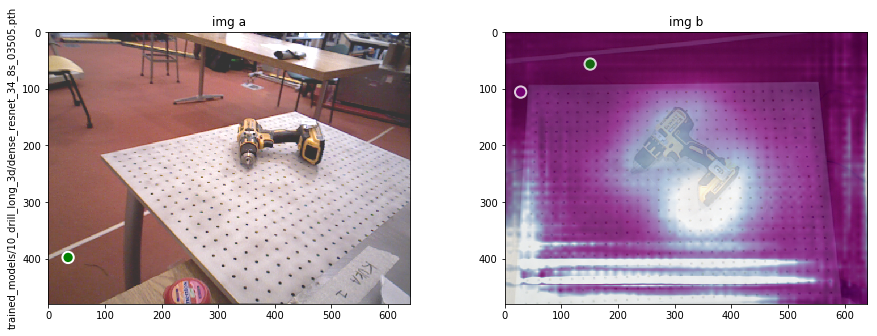

(480, 640)
descriptor_at_pixel:  (3,)
res_a.shape  (480, 640, 3)
norm_diffs.shape (480, 640)
best_match_tuple:  (195, 103)
best_match:  124903
min_diff:  3.750221330791562e-05


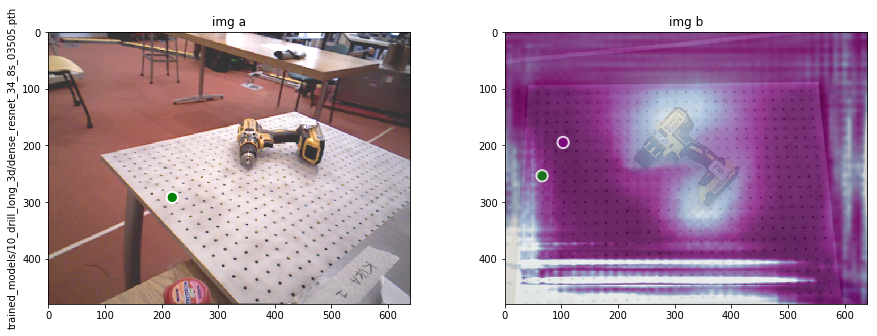

(480, 640)
descriptor_at_pixel:  (3,)
res_a.shape  (480, 640, 3)
norm_diffs.shape (480, 640)
best_match_tuple:  (350, 365)
best_match:  224365
min_diff:  0.0008729091057511212


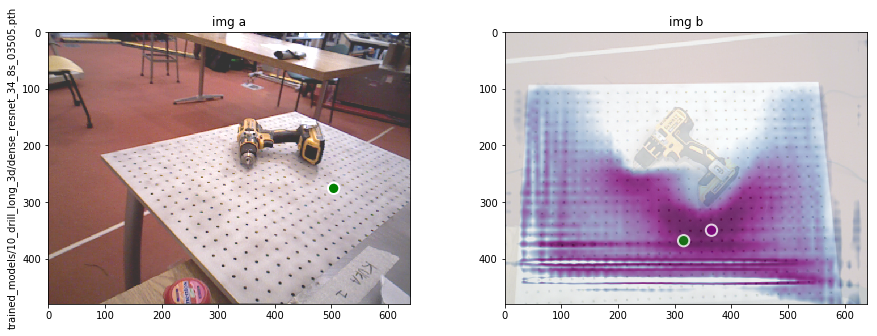

(480, 640)
descriptor_at_pixel:  (3,)
res_a.shape  (480, 640, 3)
norm_diffs.shape (480, 640)
best_match_tuple:  (441, 571)
best_match:  282811
min_diff:  0.00018547597124573493


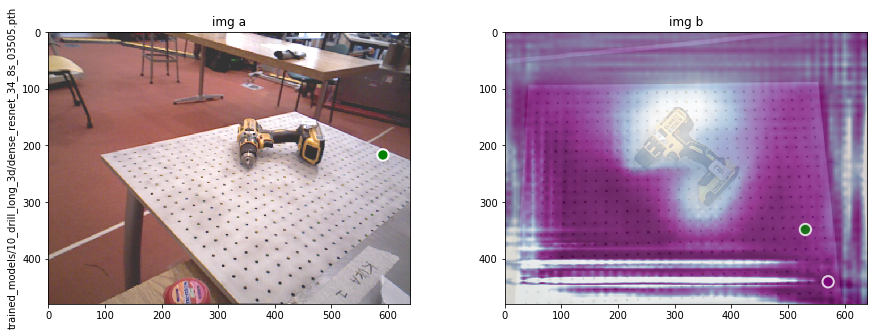

(480, 640)
descriptor_at_pixel:  (3,)
res_a.shape  (480, 640, 3)
norm_diffs.shape (480, 640)
best_match_tuple:  (405, 548)
best_match:  259748
min_diff:  0.0006366826012123607


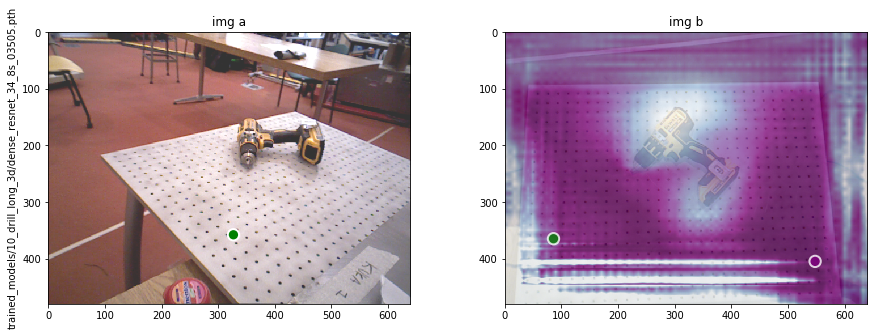

(480, 640)
descriptor_at_pixel:  (3,)
res_a.shape  (480, 640, 3)
norm_diffs.shape (480, 640)
best_match_tuple:  (441, 553)
best_match:  282793
min_diff:  0.00023349445038994224


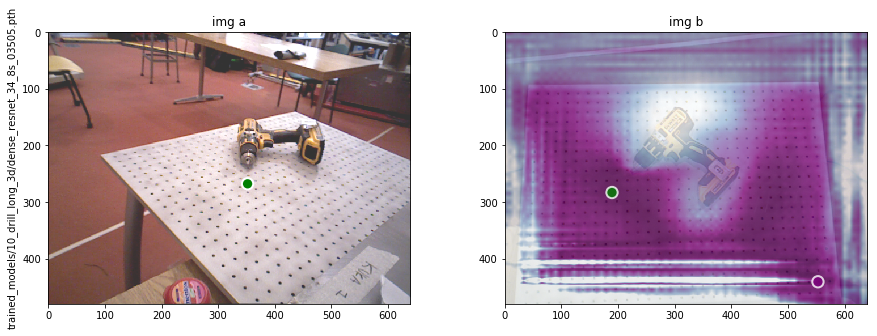

In [23]:
def make_correspondence_heatmap(pixel_a, pixel_b, img_a_rgb, img_b_rgb, res_a, res_b):
    descriptor_at_pixel = res_a[pixel_a[0], pixel_a[1]]
    norm_diffs = np.zeros_like(img_b_depth)*0.0
    print norm_diffs.shape
    print "descriptor_at_pixel: ", descriptor_at_pixel.shape
    print "res_a.shape ", res_a.shape
    for i, row in enumerate(norm_diffs):
        for j, value in enumerate(row):
            norm_diffs[i][j] = np.linalg.norm(res_b[i][j] - descriptor_at_pixel)**2
    fig, axes = plt.subplots(1, ncols=2)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    axes[0].set_title("img a")
    axes[1].set_title("img b")
    circ = Circle(pixel_a[::-1], radius=10, facecolor='g', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
    axes[0].add_patch(circ)
    axes[0].imshow(img_a_rgb, alpha=0.8)
    axes[1].imshow(norm_diffs, cmap=plt.cm.BuPu_r, vmax=2)
    axes[1].imshow(img_b_rgb, alpha=0.2)
    circ = Circle(pixel_b[::-1], radius=10, facecolor='g', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid', alpha=0.8)
    axes[1].add_patch(circ)
    # plot best match
    best_match = np.argmin(norm_diffs)
    print "norm_diffs.shape", norm_diffs.shape
    best_match_tuple = np.unravel_index(best_match, norm_diffs.shape)
    print "best_match_tuple: ", best_match_tuple
    print "best_match: ", best_match
    min_diff = norm_diffs[best_match_tuple]
    print "min_diff: ", min_diff
    best_match = (best_match/640, best_match%640)
    circ = Circle(best_match[::-1], radius=10, facecolor='purple', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid', alpha=0.8)
    axes[1].add_patch(circ)
    axes[0].set_ylabel(this_net)
    plt.show()
    
res_a = forward_on_img(this_net, img_a_rgb)
res_b = forward_on_img(this_net, img_b_rgb)
for i in range(len(uv_a[0])):
    if i >= 10:
        break
    sample_from_a = (uv_a[1][i], uv_a[0][i])
    answer_from_b = (uv_b[1][i], uv_b[0][i])
    make_correspondence_heatmap(sample_from_a, answer_from_b, img_a_rgb, img_b_rgb, res_a, res_b)

## How about correspondences from lots of different views, different scenes?

In [ ]:
lf = LabelFusionDataset()
for i in range(10):
    scene_directory = lf.get_random_scene_directory()
    img_a_rgb, img_a_depth, img_a_pose = lf.get_random_rgbd_with_pose(scene_directory)
    img_b_rgb, img_b_depth, img_b_pose = lf.get_different_rgbd_with_pose(scene_directory, img_a_pose)
    uv_a, uv_b = cf.batch_find_pixel_correspondences(img_a_depth, img_a_pose, 
                                                    img_b_depth, img_b_pose, 
                                                    num_attempts=100)

    res_a = forward_on_img(this_net, img_a_rgb)
    res_b = forward_on_img(this_net, img_b_rgb)

    sample_from_a = (uv_a[1][0], uv_a[0][0])
    answer_from_b = (uv_b[1][0], uv_b[0][0])
    make_correspondence_heatmap(sample_from_a, answer_from_b, img_a_rgb, img_b_rgb, res_a, res_b)


## What do the descriptors look like in different scenes?

In [ ]:
scene = "2017-06-13-01"
img_a_index = "0000000001"
img_a_rgb, img_a_depth, img_a_pose = lf.get_specific_rgbd_with_pose(scene, img_a_index)
img_b_index = "0000001000"
img_b_rgb, img_b_depth, img_b_pose = lf.get_specific_rgbd_with_pose(scene, img_b_index)

res_a = forward_on_img(this_net, img_a_rgb)
res_b = forward_on_img(this_net, img_b_rgb)

if (descriptor_dimensionality == 1) or (descriptor_dimensionality == 3):
    fig, axes = plt.subplots(nrows=3, ncols=2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    axes = axes.flat[0:]
    images = [img_a_rgb, img_b_rgb, img_a_depth, img_b_depth, normalize(res_a), normalize(res_b)]
    for ax, img in zip(axes, images):
        ax.imshow(img)
    plt.show()

In [ ]:
this_net = nets[-1]
if (descriptor_dimensionality == 1) or (descriptor_dimensionality == 3):
    fig, axes = plt.subplots(1, ncols=2)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    axes[0].set_title("img a")
    axes[1].set_title("img b")
    axes[0].imshow(normalize(forward_on_img(this_net, img_a_rgb)))
    axes[0].imshow(img_a_rgb, alpha=0.5)
    axes[1].imshow(normalize(forward_on_img(this_net, img_b_rgb)))
    axes[1].imshow(img_b_rgb, alpha=0.5)
    axes[0].set_ylabel(this_net)
    plt.show()

In [ ]:
scene = "2017-06-13-15"
img_a_index = "0000000001"
img_a_rgb, img_a_depth, img_a_pose = lf.get_specific_rgbd_with_pose(scene, img_a_index)
img_b_index = "0000001000"
img_b_rgb, img_b_depth, img_b_pose = lf.get_specific_rgbd_with_pose(scene, img_b_index)

res_a = forward_on_img(this_net, img_a_rgb)
res_b = forward_on_img(this_net, img_b_rgb)

if (descriptor_dimensionality == 1) or (descriptor_dimensionality == 3):
    fig, axes = plt.subplots(nrows=3, ncols=2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    axes = axes.flat[0:]
    images = [img_a_rgb, img_b_rgb, img_a_depth, img_b_depth, normalize(res_a), normalize(res_b)]
    for ax, img in zip(axes, images):
        ax.imshow(img)
    plt.show()

In [ ]:
scene = "2017-06-13-16"
img_a_index = "0000000200"
img_a_rgb, img_a_depth, img_a_pose = lf.get_specific_rgbd_with_pose(scene, img_a_index)
img_b_index = "0000001000"
img_b_rgb, img_b_depth, img_b_pose = lf.get_specific_rgbd_with_pose(scene, img_b_index)

res_a = forward_on_img(this_net, img_a_rgb)
res_b = forward_on_img(this_net, img_b_rgb)

if (descriptor_dimensionality == 1) or (descriptor_dimensionality == 3):
    fig, axes = plt.subplots(nrows=3, ncols=2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    axes = axes.flat[0:]
    images = [img_a_rgb, img_b_rgb, img_a_depth, img_b_depth, normalize(res_a), normalize(res_b)]
    for ax, img in zip(axes, images):
        ax.imshow(img)
    plt.show()

## What if we try to find a match for the drill, in a different scene?

In [24]:
scene = "2017-06-13-12"
img_a_index = "0000000001"
img_a_rgb, img_a_depth, img_a_pose = lf.get_specific_rgbd_with_pose(scene, img_a_index)

scene = "2017-06-13-01"
img_b_index = "0000000800"
img_b_rgb, img_b_depth, img_b_pose = lf.get_specific_rgbd_with_pose(scene, img_b_index)

# I have to choose these samples by hand, since don't have ground truth for matching between scenes
sample_from_a = (200, 350)
answer_from_b = (200, 4500)

res_a = forward_on_img(this_net, img_a_rgb)
res_b = forward_on_img(this_net, img_b_rgb)

make_correspondence_heatmap(sample_from_a, answer_from_b, img_a_rgb, img_b_rgb, res_a, res_b)

IOError: [Errno 2] No such file or directory: '/home/manuelli/code/data_volume/10_scenes_drill_long/2017-06-13-12/images/0000000001_rgb.png'

In [ ]:
scene = "2017-06-13-12"
img_a_index = "0000000001"
img_a_rgb, img_a_depth, img_a_pose = lf.get_specific_rgbd_with_pose(scene, img_a_index)

scene = "2017-06-13-15"
img_b_index = "0000000001"
img_b_rgb, img_b_depth, img_b_pose = lf.get_specific_rgbd_with_pose(scene, img_b_index)

# I have to choose these samples by hand, since don't have ground truth for matching between scenes
sample_from_a = (140, 350)
answer_from_b = (2500, 285)

res_a = forward_on_img(this_net, img_a_rgb)
res_b = forward_on_img(this_net, img_b_rgb)

make_correspondence_heatmap(sample_from_a, answer_from_b, img_a_rgb, img_b_rgb, res_a, res_b)

In [ ]:
scene = "2017-06-13-12"
img_a_index = "0000000001"
img_a_rgb, img_a_depth, img_a_pose = lf.get_specific_rgbd_with_pose(scene, img_a_index)

scene = "2017-06-13-16"
img_b_index = "0000000201"
img_b_rgb, img_b_depth, img_b_pose = lf.get_specific_rgbd_with_pose(scene, img_b_index)

# I have to choose these samples by hand, since don't have ground truth for matching between scenes
sample_from_a = (145, 340)
answer_from_b = (2500, 285)

res_a = forward_on_img(this_net, img_a_rgb)
res_b = forward_on_img(this_net, img_b_rgb)

make_correspondence_heatmap(sample_from_a, answer_from_b, img_a_rgb, img_b_rgb, res_a, res_b)